In [26]:
import pandas as pd
import os
import glob

In [27]:
path = 'clustered_json/'
frames = []
for filename in glob.glob(os.path.join(path, '*.json')): #only process .JSON files in folder.      
    with open(filename, encoding='utf-8', mode='r') as currentFile:
        frames.append(pd.read_json(currentFile, orient='index'))

df = pd.concat(frames)
df.drop(['authors', 'image_url', 'localpath', 'title_page', 'title_rss'], axis = 1, inplace = True)
df.head(3)

,date_download,date_modify,date_publish,description,language,source_domain,maintext,title,url
0,"06/30/2021, 22:17:27","06/30/2021, 22:17:27","01/17/2020, 16:54:29",Editor's note: Anderson Cooper explains why a ...,en,ac360.blogs.cnn.com,Editor's note: Anderson Cooper explains why a ...,The RidicuList: JcPenney – Anderson Cooper 360...,https://ac360.blogs.cnn.com/2011/09/01/the-rid...
1,"06/30/2021, 22:17:27","06/30/2021, 22:17:27","01/17/2020, 16:39:12",For the latest updates to Global Public Square...,en,globalpublicsquare.blogs.cnn.com,For the latest updates to Global Public Square...,Global Public Square has moved – Global Public...,https://globalpublicsquare.blogs.cnn.com/2015/...
2,"06/30/2021, 22:17:27","06/30/2021, 22:17:27","01/17/2020, 16:06:12",For the latest updates to Global Public Square...,en,globalpublicsquare.blogs.cnn.com,For the latest updates to Global Public Square...,Global Public Square has moved – Global Public...,https://globalpublicsquare.blogs.cnn.com/2015/...


In [28]:
amount_of_articles = len(df["maintext"])
print(f"Amount of articles: {amount_of_articles}")

Amount of articles: 829


In [29]:
import re  
import nltk 
nltk.download('stopwords')  
from nltk.corpus import stopwords 

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Nicolas\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [30]:
X = df.maintext.values

processed_articles = []
 
for article in range(0, len(X)):  
    # Remove all the special characters
    processed_article = re.sub(r'\W', ' ', str(X[article]))
 
    # remove all single characters
    processed_article = re.sub(r'\s+[a-zA-Z]\s+', ' ', processed_article)
 
    # Remove single characters from the start
    processed_article = re.sub(r'\^[a-zA-Z]\s+', ' ', processed_article) 
 
    # Substituting multiple spaces with single space
    processed_article= re.sub(r'\s+', ' ', processed_article, flags=re.I)
 
    # Removing prefixed 'b'
    processed_article = re.sub(r'^b\s+', '', processed_article)
 
    # Converting to Lowercase
    processed_article = processed_article.lower()
 
    processed_articles.append(processed_article)

In [31]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidfconverter = TfidfVectorizer(max_features=2000, min_df=5, max_df=0.7, stop_words=stopwords.words('english'))  
tfidf = tfidfconverter.fit_transform(processed_articles)
tfidf

<829x2000 sparse matrix of type '<class 'numpy.float64'>'
	with 186141 stored elements in Compressed Sparse Row format>

In [32]:
from sklearn.metrics.pairwise import cosine_distances

cosine_similarity = cosine_distances(tfidf)
cosine_similarity

array([[0.        , 0.99352708, 0.90509819, ..., 0.80213081, 0.91433595,
        0.97160405],
       [0.99352708, 0.        , 0.96958281, ..., 0.98460194, 0.99069933,
        0.99813463],
       [0.90509819, 0.96958281, 0.        , ..., 0.9293769 , 0.9145259 ,
        0.99008659],
       ...,
       [0.80213081, 0.98460194, 0.9293769 , ..., 0.        , 0.90626495,
        0.97930639],
       [0.91433595, 0.99069933, 0.9145259 , ..., 0.90626495, 0.        ,
        0.97579898],
       [0.97160405, 0.99813463, 0.99008659, ..., 0.97930639, 0.97579898,
        0.        ]])

In [33]:
from sklearn.cluster import AffinityPropagation

clustering = AffinityPropagation(affinity='precomputed', damping=0.5, random_state=5)
clustering.fit(cosine_similarity)
labels = clustering.labels_
#cluster_centers = clustering.cluster_centers_
cluster_centers_indices = clustering.cluster_centers_indices_
n_clusters_ = len(cluster_centers_indices)

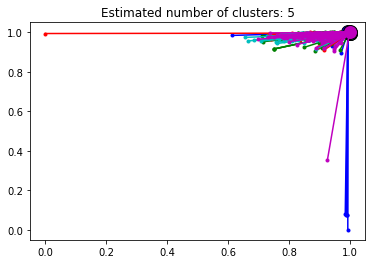

In [34]:
import matplotlib.pyplot as plt
from itertools import cycle

plt.close('all')
plt.figure(1)
plt.clf()

colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(n_clusters_), colors):
    class_members = labels == k
    cluster_center = cosine_similarity[cluster_centers_indices[k]]
    plt.plot(cosine_similarity[class_members, 0], cosine_similarity[class_members, 1], col + '.')
    plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=14)
    for x in cosine_similarity[class_members]:
        plt.plot([cluster_center[0], x[0]], [cluster_center[1], x[1]], col)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()